In [1]:
# fit PCA on the hormone data with speed as exogenous variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from statsmodels.tsa.stattools import pacf
from matplotlib.gridspec import GridSpec

# import robust, Spearman based PCA
import SpearmanPCA
import os

In [2]:
figures_dir = '../../figures/fig3/'
supp_figures_dir = '../../figures/supp/'

In [3]:
# load data
horm_beh = np.load('../../data/processed/compounds_aligned_speed.npy', allow_pickle=True).item()
X1m = horm_beh['X1m'].T
X1a = horm_beh['X1a'].T
X2m = horm_beh['X2m'].T
X2a = horm_beh['X2a'].T
X3 = horm_beh['X3'].T
y1m = horm_beh['y1m']
y1a = horm_beh['y1a']
y2m = horm_beh['y2m']
y2a = horm_beh['y2a']
y3 = horm_beh['y3']
common_comps = horm_beh['common_comps']

In [4]:
# define functions

# spearman R cross correlation
def spearman_ccf(x, y, max_lag):
    lags = np.arange(-max_lag+1, max_lag)
    ccf = [spearmanr(x[max_lag+lag:-max_lag+lag], 
                     y[max_lag: -max_lag])[0] for lag in lags]
    return lags, ccf


def robust_zscore(data, axis=0, log_transform=False):
    if log_transform:
        data = np.log(data)
    median = np.nanmedian(data, axis=axis)
    mad = np.nanmedian(np.abs(data - median), axis=axis)
    zscore = (data - median) / mad
    return zscore

# define function to plot matrix reordered according to cluster identity
def plot_clustered_corr(corr, clusters):
    # order by clusters
    order = np.argsort(clusters)
    clustered_corr = corr[order][:, order]
    plt.figure(figsize=(3, 3))
    plt.imshow(clustered_corr, vmin=-1, vmax=1, cmap='bwr')
    plt.title('Clustered Spearman Correlation Matrix')
    plt.tight_layout()
    
# compute within block vs outside block correlations
def compute_block_correlations(mat, clusters):
    within_block_corrs = []
    outside_block_corrs = []
    for i in range(1, 6):
        block_indices = clusters == i
        outside_indices = clusters != i
        block_corrs = mat[:, block_indices][block_indices]
        outside_corrs = mat[:, outside_indices][block_indices]
        # get upper triangle values excluding diagonal
        within_block_corrs.extend(block_corrs[np.triu_indices_from(block_corrs, k=1)])
        outside_block_corrs.extend(outside_corrs.flatten())
    return np.median(within_block_corrs)/np.median(outside_block_corrs)


# per animal spearman correlation matrices
def plot_spearman_corr(X, title):
    corr, _ = spearmanr(X)
    plt.imshow(corr, vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar(label='Spearman correlation', fraction=0.046, pad=0.04)
    plt.title(title)


def comp_resids(X, y): # compute residuals of each compound in X after regressing out y
    n_compounds = X.shape[1]
    resids = np.zeros_like(X)
    for i in range(n_compounds):
        model = LinearRegression().fit(y.reshape(-1, 1), X[:, i])
        resids[:, i] = X[:, i] - model.predict(y.reshape(-1, 1))
    return resids

def partial_corr(X, y):
    n_compounds = X.shape[1]
    resids = comp_resids(X, y)
    p_corr = np.zeros((n_compounds, n_compounds))
    for i in range(n_compounds):
        for j in range(n_compounds):
            if i == j:
                p_corr[i, j] = 1.0
            else:
                # compute correlation between residuals
                # p_corr[i, j] = np.corrcoef(resids[:, i], resids[:, j])[0, 1]
                # use robust Spearman correlation instead of Pearson
                p_corr[i, j] = spearmanr(resids[:, i], resids[:, j])[0]
    return p_corr


def plot_partial_corr(p_corr, title):
    plt.imshow(p_corr, vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar(label='Partial Spearman correlation', fraction=0.046, pad=0.04)
    plt.title(title)
    plt.tight_layout()
    
# rPCA analyses
rpca = SpearmanPCA.SpearmanRobustPCA(
    n_components=20,
    gaussianize=True,   # rank → normal scores
    center='median',
    scale='mad',
    handle_missing='pairwise',
    whiten=False
)

In [5]:
# robust z-score each individual compound per animal first
X1 = robust_zscore(np.concatenate([X1m, X1a], axis=0)) 
X2 = robust_zscore(np.concatenate([X2m, X2a], axis=0))
X3 = robust_zscore(X3)

y1 = np.concatenate([y1m, y1a], axis=0)
y2 = np.concatenate([y2m, y2a], axis=0)
y3 = y3

# concatenate data after z-scoring each animal individually
X = np.concatenate([X1, X2, X3], axis=0)
y = np.concatenate([y1, y2, y3], axis=0)
n_samples, n_features = X.shape

# print shapes to check consistency
print(X.shape, y.shape)

(163, 123) (163,)


## Spearman correlation matrices, clustering, and controls

In [6]:
# cluster spearman correlation matrix into 5 clusters using hierarchical clustering
Z = linkage(spearmanr(X)[0], method='ward')
clusters = fcluster(Z, 5, criterion='maxclust')

In [7]:
compute_block_correlations(spearmanr(X)[0], clusters)

np.float64(4.048311224672508)

## Figure 3B

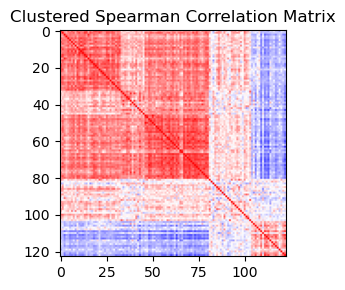

In [8]:
plot_clustered_corr(spearmanr(X)[0], clusters)
plt.savefig(figures_dir+'3B_clustered_spearman_corr_matrix_with_dendrogram.eps', dpi=600)

In [9]:
# rPCA analysis
X_reduced = rpca.fit_transform(X)
evr=rpca.explained_variance_ratio_
print(evr)
print('')
print('% variance explained by the first {} components: {:.2f}%'.format(len(evr[0:10]),np.sum(evr[0:10])*100))

[0.35491042 0.0924889  0.06012161 0.05198933 0.04190263 0.03101641
 0.03035897 0.02842722 0.02196976 0.01903008 0.01657813 0.01450866
 0.01373105 0.01284903 0.01111664 0.01091736 0.01022815 0.00972646
 0.0077707  0.00738159]

% variance explained by the first 10 components: 73.22%


## Figure 3C

percent variance explained by first 10 components:  73.22153402709914
statistic -0.63 and pval 0.0000


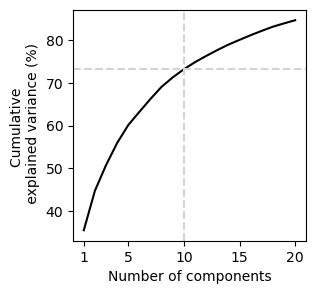

In [10]:
plt.figure(figsize=(3, 3))
plt.plot(np.cumsum(rpca.explained_variance_ratio_)*100,c='k')
plt.xlabel('Number of components')
plt.ylabel('Cumulative \n explained variance (%)')
plt.axvline(x=9, color='lightgrey', linestyle='--')
plt.axhline(y=np.sum(rpca.explained_variance_ratio_[0:10])*100, color='lightgrey', linestyle='--')
# renumbering ticks to switch from pythonic 0 indexing to more human-readable 1 indexing
plt.xticks([0,4,9,14,19],[1,5,10,15,20])
plt.savefig(figures_dir+'3C_rpca_explained_variance.eps', dpi=300)

print('percent variance explained by first 10 components: ',np.sum(rpca.explained_variance_ratio_[0:10])*100)
[spearman_stat,pval]=spearmanr(X_reduced[1:, 0], y[:-1])
print('statistic {:.2f} and pval {:.4f}'.format(spearman_stat,pval))


## Figure 3D


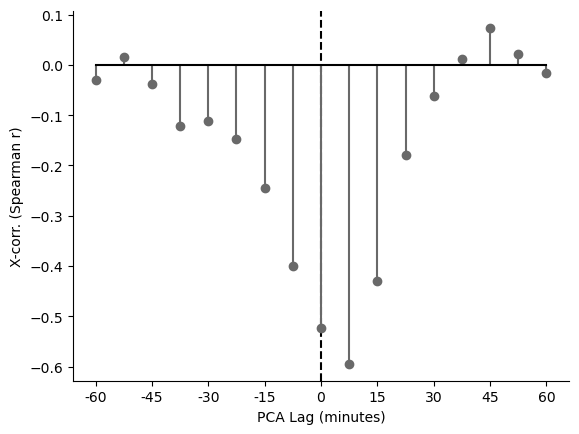

In [11]:
# cross-correlation of first PC with behavior
maxlag = 8
fig, ax = plt.subplots()
ax.axvline(0, color='k', linestyle='--')

xvals,yvals=spearman_ccf(X_reduced[:, 0], y, max_lag=maxlag+1)

ax.stem(xvals,yvals,'dimgrey',basefmt='k')
ax.set_xlabel('PCA Lag (minutes)')
ax.set_ylabel('X-corr. (Spearman r)')
ax.set_xticks(np.arange(-maxlag, maxlag + 1, 2))
ax.set_xticklabels((np.arange(-maxlag, maxlag + 1, 2)*7.5).astype(int))
ax.spines[['top','right']].set_visible(False)
plt.savefig(figures_dir+'3D_rPCA1_vs_locomotion.eps', dpi=600)
plt.show()


In [12]:
# print] spearman r for rPC1 lags vs locomotion
for i in np.arange(0,len(xvals)):
    print(xvals[i]*7.5,  "yvalue: {:.03f}".format(yvals[i]))

-60.0 yvalue: -0.030
-52.5 yvalue: 0.015
-45.0 yvalue: -0.037
-37.5 yvalue: -0.121
-30.0 yvalue: -0.111
-22.5 yvalue: -0.147
-15.0 yvalue: -0.246
-7.5 yvalue: -0.400
0.0 yvalue: -0.523
7.5 yvalue: -0.595
15.0 yvalue: -0.429
22.5 yvalue: -0.178
30.0 yvalue: -0.061
37.5 yvalue: 0.013
45.0 yvalue: 0.073
52.5 yvalue: 0.021
60.0 yvalue: -0.016


In [13]:

# loading analyses of PC1 -- which compounds have strong loadings?
loadings = rpca.components_.T  # shape (n_features, n_components)
pc1_loadings = loadings[:, 0]  # first principal component loadings

# sort by absolute value of loadings
sorted_indices = np.argsort(np.abs(pc1_loadings))[::-1]
sorted_loadings = pc1_loadings[sorted_indices]
sorted_compounds = np.array(common_comps)[sorted_indices]
sorted_compounds[:20], sorted_loadings[:20]

(array(['Threonine', 'Lysyl-Glutamic acid', 'Proline',
        'Methionyl-Glutamic acid',
        'Glutamyl-Methionine/Methionyl-Glutamic acid', 'Asparagine',
        'Serine', 'Alanine', 'Histidine', 'Glutamyl-Alanine',
        'Glutamyl-Phenylalanine', 'Pantothenic acid', 'Phenylalanine',
        'Aminoadipic acid',
        'Glutamic acid/L-4-Hydroxyglutamate semialdehyde',
        'Prolyl-Proline', 'Arginine', 'Isomer 2 of 5-Aminopentanoic acid',
        'L-Cysteinylglycine disulfide', '3-Hydroxy-L-proline'],
       dtype='<U50'),
 array([-0.13524548, -0.13360042, -0.13170755, -0.13133642, -0.13048558,
        -0.12843575, -0.12802323, -0.12795197, -0.12726796, -0.12524618,
        -0.12483607, -0.12340684, -0.12251253, -0.11948936, -0.11925188,
        -0.11871388, -0.11868173, -0.1175677 , -0.11701948, -0.11693712]))

# Interactions across compounds / partial xcorrs

In [12]:
# compute residuals of X1 vs y1, X2 vs y2, X3 vs y3
X1_resids = comp_resids(X1, y1)
X2_resids = comp_resids(X2, y2)
X3_resids = comp_resids(X3, y3)
X_resids = np.concatenate([X1_resids, X2_resids, X3_resids], axis=0)
timebins = [0,10,20,30,40,50,60]
timesoftimebins= [int(timeval*7.5) for timeval in timebins]


## Supplementary Figure 8 (top left)

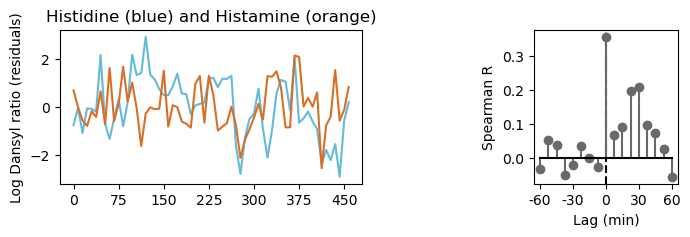

In [13]:
# plot histamine and histidine residuals time series, xcorr
histamine_idx = common_comps.index('Histamine')
histidine_idx = common_comps.index('Histidine')

fig = plt.figure(figsize=(9,2))
gs = GridSpec(1,9,figure=fig)

ax1=fig.add_subplot(gs[0,1:5])
plt.plot(X3_resids[:, histidine_idx], label='Histidine',c="#65BADA")
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X3_resids[:, histamine_idx], label='Histamine', c="#D86F27")
plt.xticks(timebins,timesoftimebins)
plt.title('Histidine (blue) and Histamine (orange)')


ax2=fig.add_subplot(gs[0,7:9])
lags, ccf_histamine_histidine = spearman_ccf(X_resids[:, histidine_idx],X_resids[:, histamine_idx],max_lag=9)

plt.axvline(0, color='k', linestyle='--')
plt.stem(lags, ccf_histamine_histidine, linefmt='dimgrey', markerfmt='o',basefmt='k')
plt.xticks([-8,-4,0,4,8], [-60,-30,0,30,60])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig(os.path.join(supp_figures_dir,'S8_histidine-histimine.eps'),dpi=600)

## Supplementary Figure 8 (right)

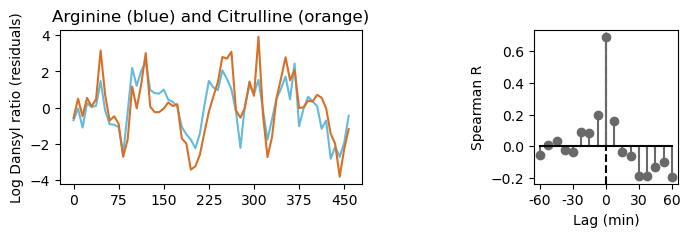

In [14]:
# same for arginine and citrulline

# plot histamine and histidine residuals time series, xcorr
arginine_idx = common_comps.index('Arginine')
citrulline_idx = common_comps.index('Citrulline')

fig = plt.figure(figsize=(9,2))
gs = GridSpec(1,9,figure=fig)

ax1=fig.add_subplot(gs[0,1:5])
plt.plot(X3_resids[:, arginine_idx], label='Arginine',c="#65BADA")
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X3_resids[:, citrulline_idx], label='Citrulline', c="#D86F27")
plt.xticks(timebins,timesoftimebins)
plt.title('Arginine (blue) and Citrulline (orange)')


ax2=fig.add_subplot(gs[0,7:9])
lags, ccf_arginine_citrulline = spearman_ccf(X_resids[:, arginine_idx],X_resids[:, citrulline_idx],max_lag=9)

plt.axvline(0, color='k', linestyle='--')
plt.stem(lags, ccf_arginine_citrulline, linefmt='dimgrey', markerfmt='o',basefmt='k')
plt.xticks([-8,-4,0,4,8], [-60,-30,0,30,60])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig(supp_figures_dir+'S8_arginine_citrulline_ccg.eps', dpi=600)

## Supplementary Figure 8 (bottom)

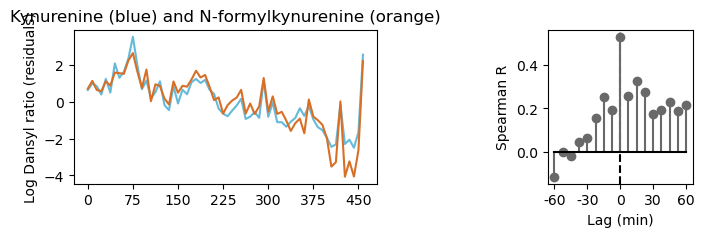

In [15]:
# same for arginine and citrulline

# plot histamine and histidine residuals time series, xcorr
kynurenine_idx = common_comps.index('Kynurenine')
nformylynurenine_idx = common_comps.index('N-formylkynurenine')

fig = plt.figure(figsize=(9,2))
gs = GridSpec(1,9,figure=fig)

ax1=fig.add_subplot(gs[0,1:5])
plt.plot(X3_resids[:, kynurenine_idx], label='Kynurenine',c="#65BADA")
plt.ylabel('Log Dansyl ratio (residuals)')
plt.plot(X3_resids[:, nformylynurenine_idx], label='N-formylkynurenine', c="#D86F27")
plt.xticks(timebins,timesoftimebins)
plt.title('Kynurenine (blue) and N-formylkynurenine (orange)')


ax2=fig.add_subplot(gs[0,7:9])
lags, ccf_kynurenine_nformylynurenine = spearman_ccf(X_resids[:, kynurenine_idx],X_resids[:, nformylynurenine_idx],max_lag=9)

plt.axvline(0, color='k', linestyle='--')
plt.stem(lags, ccf_kynurenine_nformylynurenine, linefmt='dimgrey', markerfmt='o',basefmt='k')
plt.xticks([-8,-4,0,4,8], [-60,-30,0,30,60])
plt.xlabel('Lag (min)')
plt.ylabel('Spearman R')
plt.savefig(supp_figures_dir+'S8_kynurenine_nformylynurenine_ccg.eps', dpi=600)



## Supplementary Figure 9A

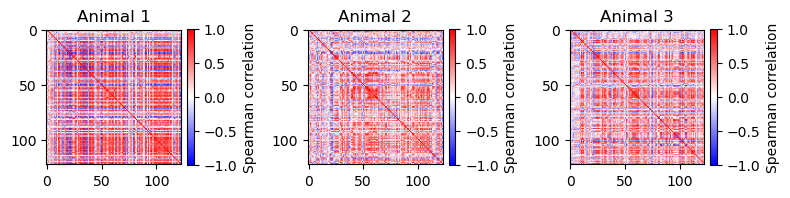

Cosine similarity between spearman correlation matrices:
[0.6376724  0.67606391 0.57439527]
P-values
[np.float64(0.0), np.float64(0.0), np.float64(0.0)]

Animal 1 blockiness: 5.925910064239829
Animal 2 blockiness: 3.9567198177676532
Animal 3 blockiness: 3.953288846520495


In [16]:
plt.figure(figsize=(8, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_spearman_corr([X1, X2, X3][i], f'Animal {i + 1}')
plt.tight_layout()
plt.savefig(supp_figures_dir+'S9A_spearman_corr_matrices.eps', dpi=600)
plt.show()

# compute cosine similarity across the three spearman correlation matrices
rs = [spearmanr(Xi)[0] for Xi in [X1, X2, X3]]
sim_matrix = cosine_similarity([r.flatten() for r in rs])
# p-values
p_values = [spearmanr(rs[h].flatten(), rs[k].flatten())[1] for (h,k) in [(0,1), (0,2), (1,2)]]
print("Cosine similarity between spearman correlation matrices:")
print(sim_matrix[np.triu_indices(3, k=1)])
print("P-values")
print(p_values)
print()
# compute blockiness for each animal
for i, Xi in enumerate([X1, X2, X3]):
    r = spearmanr(Xi)[0]
    blockiness = compute_block_correlations(r, clusters)
    print(f"Animal {i + 1} blockiness: {blockiness}")

## Supplementary Figure 9B

In [17]:
# partial correlation between compounds in X taking into account y
# i.e. compute correlation between residuals of X after regressing out y

# compute partial correlation for each compound in each dataset
pacs = {}
for name, data, speed in zip(['X1', 'X2', 'X3'], [X1, X2, X3], [y1, y2, y3]):
    pacs[name] = partial_corr(data, speed)

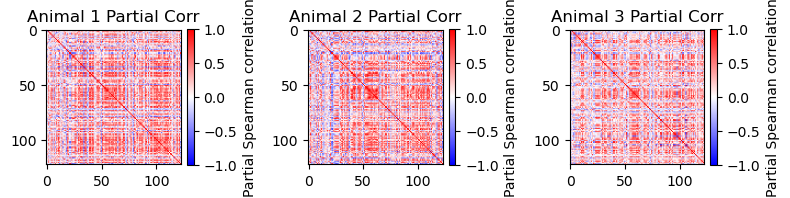

Cosine similarity between spearman correlation matrices:
[0.62511286 0.64315755 0.53149207]
P-values
[np.float64(0.0), np.float64(0.0), np.float64(0.0)]

Animal 1 partial correlation blockiness: 4.445178335535006
Animal 2 partial correlation blockiness: 4.2456732798649215
Animal 3 partial correlation blockiness: 5.229910714285714


In [18]:
# plot the three partial correlation matrices
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_partial_corr(pacs[f'X{i + 1}'], f'Animal {i + 1} Partial Corr')
plt.savefig(supp_figures_dir+'S9B_partial_spearman_corr_matrices.eps', dpi=600)
plt.show()
# compute cosine similarity across the three partial spearman correlation matrices
sim_matrix = cosine_similarity([r.flatten() for r in pacs.values()])
print("Cosine similarity between spearman correlation matrices:")
print(sim_matrix[np.triu_indices(3, k=1)])
# p-values
rs = [r for r in pacs.values()]
p_values = [spearmanr(rs[h].flatten(), rs[k].flatten())[1] for (h,k) in [(0,1), (0,2), (1,2)]]
print("P-values")
print(p_values)
print()

# compute blockiness for each animal
for i, name in enumerate(['X1', 'X2', 'X3']):
    r = pacs[name]
    blockiness = compute_block_correlations(r, clusters)
    print(f"Animal {i + 1} partial correlation blockiness: {blockiness}")

## Supplementary Figure 9C

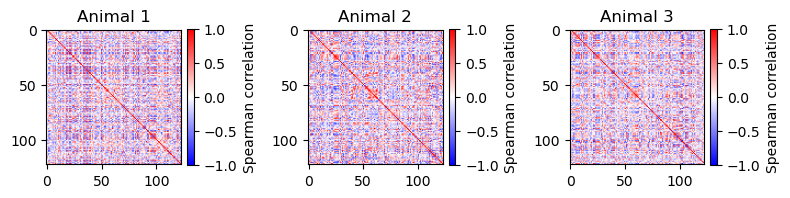

X1n v X1: significance stat: 0.8043535788665036, p-value 0.0
X2n v X2: significance stat: 0.8604904248061116, p-value 0.0
X3n v X3: significance stat: 0.8500821903325174, p-value 0.0


In [19]:
### Extra step, column normalize and check consistency
# # compute the spearman r for X1, X2, and X3 with the columns normalized
X1n = robust_zscore(X1.T, log_transform=False).T
X2n = robust_zscore(X2.T, log_transform=False).T
X3n = robust_zscore(X3.T, log_transform=False).T

plt.figure(figsize=(8, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_spearman_corr([X1n, X2n, X3n][i], f'Animal {i + 1}') 
plt.savefig(supp_figures_dir+'9C_spearman_corr_matrices_Columns_norm.eps', dpi=600)
plt.tight_layout()
plt.show()

# get spearman's rank correlation coefficient and p value
# comparing the rank order in the column-normalized data vs not
for i in range(3):
    [sig,p]=spearmanr([X1n,X2n,X3n][i].flatten(),[X1,X2,X3][i].flatten())
    print('X{}n v X{}: significance stat: {}, p-value {}'.format(i+1,i+1,sig,p))

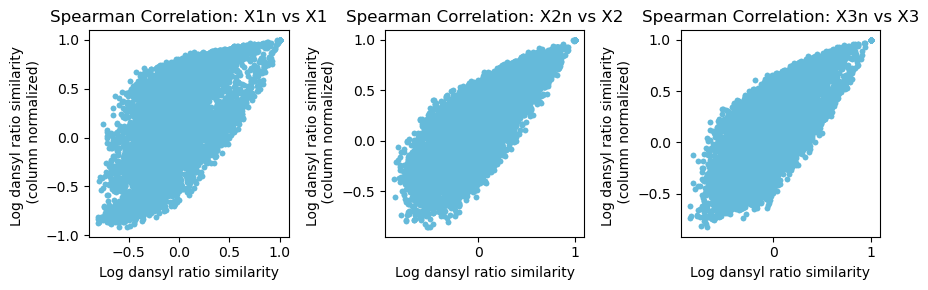

In [20]:
plt.figure(figsize=(9, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spearmanr([X1n,X2n,X3n][i])[0].flatten(), spearmanr([X1,X2,X3][i])[0].flatten(),marker='.',rasterized=True, c="#65BADA")
    plt.xlabel('Log dansyl ratio similarity')
    plt.ylabel('Log dansyl ratio similarity \n (column normalized)')
    plt.title(f'Spearman Correlation: X{i+1}n vs X{i+1}')
    plt.tight_layout()
plt.savefig(supp_figures_dir+'S9C_spearman_corr_scatter_X2n_vs_X2.eps', dpi=600)

## Supplementary Figure S10

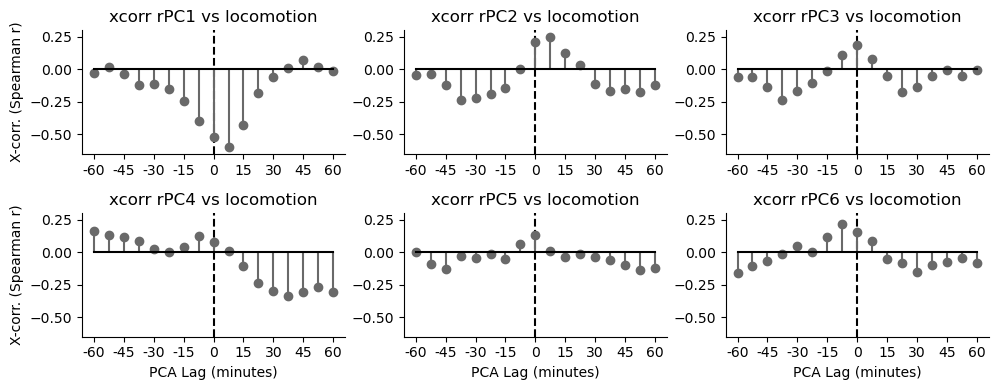

In [21]:
# cross-correlation of first 6 components
maxlag = 8
fig, axs = plt.subplots(2,3,figsize=(10,4))
ax1vals=[0,0,0,1,1,1]
ax2vals=[0,1,2,0,1,2]

for p in range(6):
    if p==0 or p==3:   
        axs[ax1vals[p],ax2vals[p]].set_ylabel('X-corr. (Spearman r)')
    if p>2:
        axs[ax1vals[p],ax2vals[p]].set_xlabel('PCA Lag (minutes)')
    axs[ax1vals[p],ax2vals[p]].axvline(0, color='k', linestyle='--')
    axs[ax1vals[p],ax2vals[p]].set_title('xcorr rPC{} vs locomotion'.format(p+1))
    axs[ax1vals[p],ax2vals[p]].stem(*spearman_ccf(X_reduced[:, p], y, max_lag=maxlag+1),'dimgrey',basefmt='k')
    axs[ax1vals[p],ax2vals[p]].set_xticks(np.arange(-maxlag, maxlag + 1, 2))
    axs[ax1vals[p],ax2vals[p]].set_xticklabels((np.arange(-maxlag, maxlag + 1, 2)*7.5).astype(int))
    axs[ax1vals[p],ax2vals[p]].spines[['top','right']].set_visible(False)
    axs[ax1vals[p],ax2vals[p]].set_ylim(-.65,.3)
#ax.xticks(np.arange(-maxlag,maxlag+1,2),labels=(np.arange(-maxlag, maxlag + 1, 2)*7.5).astype(int))

plt.tight_layout()
plt.savefig(supp_figures_dir+'S10_PCA_vs_Locomotion_multiple_PCs.eps', dpi=600)
plt.savefig('../../figures/S10_PCA_vs_Locomotion_multiple_PCs.png', dpi=600)
plt.show()